In [52]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Load data

In [53]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)



################################################################
# load data and data normalization
################################################################

inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0

n_data = output.shape[1]
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
output_loss = -np.dot(xx_mask, output) * L_x/N_s




In [54]:
PATH = "/groups/esm/dzhuang/Catheter/allparam/length/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_test_data = 300
inputX_test_raw = np.load(INPUT_X)[:,0:n_test_data]
inputY_test_raw = np.load(INPUT_Y)[:,0:n_test_data]
inputPara_test_raw = np.load(INPUT_para)[:,0:n_test_data]
output_test_raw = np.load(OUTPUT)[:,0:n_test_data]


N_s, L_x = 2001, 500


PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)



################################################################
# load data and data normalization
################################################################

inputX_test = inputX_test_raw[:, 0::3]
inputY_test = inputY_test_raw[:, 0::3]
inputPara_test = inputPara_test_raw[:, 0::3]
output_test = (output_test_raw[:, 0::3] + output_test_raw[:, 1::3] + output_test_raw[:, 2::3])/ 3.0

n_test_data = output_test.shape[1]
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
output_test_loss = -np.dot(xx_mask, output_test) * L_x/N_s


# Linear regression model

In [55]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :]
A[:, 2] = inputPara[5, :]
A[:, 3] = inputPara[6, :]


A_test = np.ones((n_test_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A_test[:, 0] = inputPara_test[2, :]
A_test[:, 1] = inputPara_test[4, :]
A_test[:, 2] = inputPara_test[5, :]
A_test[:, 3] = inputPara_test[6, :]


print("linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
print("linear regression training rel. error: ", np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  ))
print("linear regression test rel. error: ", np.mean(  np.abs(np.dot(A_test, coeff) - output_test_loss) / output_test_loss  ))


linear regression :coeff L_p, x2, x3, h, 1 =  [   5993.73724467   -8682.17376047    2475.9614333   -48534.09494157
 1114448.7126439 ]
linear regression training rel. error:  0.12406422986004143
linear regression test rel. error:  0.12707909681174598


# Fully connected neural network model

In [58]:
class Net(nn.Module):
    def __init__(self, n):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, n)
        self.fc2 = nn.Linear(n, n)
        self.fc3 = nn.Linear(n, n)
        self.fc4 = nn.Linear(n, 1)

    # x represents our data
    def forward(self, x):
      # Pass data through conv1
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.fc3(x)
        x = F.gelu(x)
        x = self.fc4(x)
        return x

batch_size = 20
learning_rate = 0.001
epochs = 1001
step_size = 100
gamma = 0.5
    

ntrain = 1000
ntest = 100

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(A[:, 0:4], dtype=torch.float), torch.tensor(output_loss.reshape(1000,1), dtype=torch.float)), batch_size=batch_size,
                                           shuffle=True)                                 
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(A_test[:, 0:4], dtype=torch.float), torch.tensor(output_test_loss.reshape(100,1), dtype=torch.float)), batch_size=batch_size,
                                          shuffle=False)


model = Net(20).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_data = np.zeros((3, epochs))

myloss = LpLoss(size_average=False)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        loss = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out =  model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
    train_l2 /= ntrain
    test_l2  /= ntest

    t2 = default_timer()
    print(ep, t2 - t1, train_l2, test_l2)

    loss_data[:, ep] = ep, train_l2, test_l2
   

0 0.13309182797092944 0.9999829502105713 0.9999494934082032
1 0.12397185800364241 0.9998159885406495 0.9995398330688476
2 0.125909214024432 0.9987806243896484 0.9974542045593262
3 0.12310940498718992 0.994739974975586 0.9904676628112793
4 0.12594581698067486 0.9834704933166504 0.9731846618652343
5 0.17424084496451542 0.9586216812133789 0.9381940460205078
6 0.12630002800142393 0.9122364959716797 0.8762652206420899
7 0.12284157599788159 0.8341991348266602 0.7767911338806153
8 0.12570300803054124 0.7136518049240113 0.6272103786468506
9 0.1228616830194369 0.5380217151641846 0.4218826389312744
10 0.12575426296098158 0.3234619936943054 0.24814592361450194
11 0.12237334699602798 0.19881944274902344 0.21458718776702881
12 0.1267624240135774 0.1853419165611267 0.21373687505722047
13 0.12502374401083216 0.18457042241096497 0.2125831127166748
14 0.12684919202001765 0.18392658162117004 0.2115556764602661
15 0.12359347700839862 0.1831759970188141 0.21044301509857177
16 0.12598510197130963 0.1824617

In [50]:
model(torch.tensor(A[:, 0:4], dtype=torch.float).cuda())

tensor([[1371174.6250],
        [ 621208.0000],
        [1138327.6250],
        [1417930.8750],
        [1311359.2500],
        [ 540563.6250],
        [1527663.5000],
        [ 606647.2500],
        [1012220.6250],
        [1492210.5000],
        [1272296.6250],
        [ 938853.6875],
        [ 527845.5000],
        [1255290.2500],
        [1440836.0000],
        [1958005.0000],
        [1035834.8125],
        [1425519.2500],
        [ 685197.1250],
        [1080806.8750],
        [1399912.1250],
        [1639753.5000],
        [ 504397.3750],
        [ 939711.7500],
        [1495725.6250],
        [1116789.5000],
        [1147721.0000],
        [1666208.8750],
        [ 833863.2500],
        [ 770544.2500],
        [ 737861.5000],
        [1123248.3750],
        [1307005.0000],
        [1112724.3750],
        [1391214.6250],
        [1525754.3750],
        [ 718957.8750],
        [ 494447.6250],
        [ 559064.0000],
        [1048293.8750],
        [1611189.3750],
        [1379729

In [37]:
torch.tensor(np.transpose(A)).size(0)

5

# Geo-FNO model

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)

print(count_params(model))
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)

ntrain = n_data
x_train = input.to(device).reshape(ntrain, N_s, 2)
pred = np.zeros((n_data, N_s))
for i in range(n_data):
    pred[i, :] = torch.exp(model(x_train[i:i+1,:,:].to(device))).detach().cpu().numpy().flatten()
    
    
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
fno_loss = -np.dot(pred, xx_mask) * L_x/N_s

print("FNO mean loss error: ",  np.mean(  np.abs(fno_loss - output_loss) / output_loss  ) )
print("FNO max loss error: ",  np.max(  np.abs(fno_loss - output_loss) / output_loss  ) )



1336001
FNO mean loss error:  0.013537512354415792
FNO max loss error:  0.11912474868594314


# Landscape of the loss function around the optimal design

In [7]:
L_p, h = 62.2564697265625,  29.99827766418457
L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

# 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
nx2, nx3 = 60*2+1, np.int64((L_p/2-15)*2+1)
x2_range = np.linspace(-L_p, 0.0, nx2)
# x3_range = np.linspace(-L_p/2+15, 0.0, nx3)
# x2_range = np.linspace(-40, 0.0, nx2)
x3_range = np.linspace(-20, 0.0, nx3)
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(x3_range)))
for i in range(len(x2_range)):
    for j in range(len(x3_range)):
        x2, x3 = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(x3_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        
        out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
                
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        

(33, 121) (33, 121) (121, 33)


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


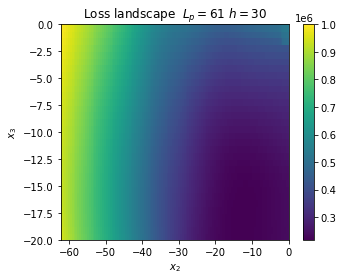

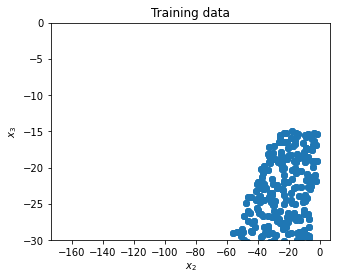

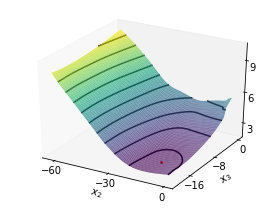

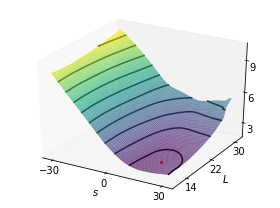

In [8]:
X, Y = np.meshgrid(x2_range ,x3_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
# plt.colorbar(format='%.0e')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Loss landscape "+r" $L_p=61 ~ h=30$")
plt.tight_layout()
plt.savefig("landscape-x2-x3.pdf")

plt.figure(figsize=(5,4))
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Training data")
plt.ylim([-30, 0])


fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
print(X.shape, Y.shape, loss.shape)
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")
ax.scatter([-11.565677642822266], [-15.864848136901855], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, linewidth=0)
ax.grid(False)

ax.view_init(30, -60)
ax.set_xticks([0, -30, -60])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$x_2$", labelpad=-5)
ax.set_yticks([0, -8, -16])
ax.tick_params(axis='y', which='major', pad=-4)

ax.set_ylabel(r"$x_3$", labelpad=-5)
ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()




# update to L, s coordinate

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
x1 = L_p.item()/2.0
X += x1
Y += x1
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")
ax.scatter([-11.565677642822266 + x1], [-15.864848136901855 + x1], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, linewidth=0)
ax.grid(False)

ax.view_init(30, -60)
ax.set_xticks([30, 0, -30])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$s$", labelpad=-5)
ax.set_yticks([30, 22, 14])
ax.tick_params(axis='y', which='major', pad=-4)

ax.set_ylabel(r"$L$", labelpad=-5)
ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-1.pdf")

In [9]:
x3, h = -15.864848136901855, 29.99827766418457
x3, h =  torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

Lp_range = np.linspace(60, 100, 40*2 + 1)
x2_range = np.linspace(-60, 0, 60*2 + 1)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(Lp_range)))
for i in range(len(x2_range)):
    for j in range(len(Lp_range)):
        if Lp_range[j] + x2_range[i] < 0.0:
            loss[i,j] = np.nan
        else:
            x2, Lp = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(Lp_range[j], dtype=torch.float)
            X_Y, X, Y = catheter_mesh_1d_total_length(L_x, Lp, x2, x3, h, N_s)

            out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
            loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        
            

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


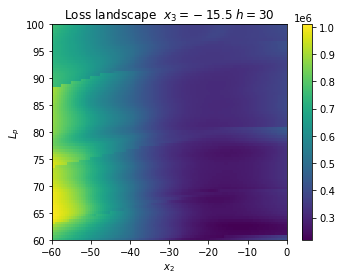

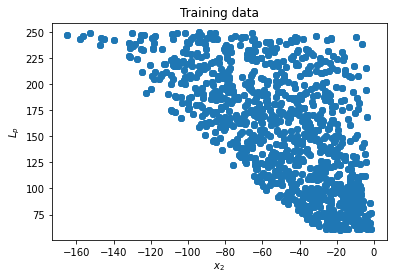

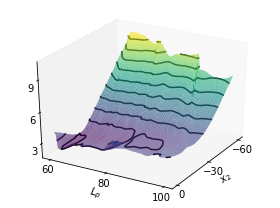

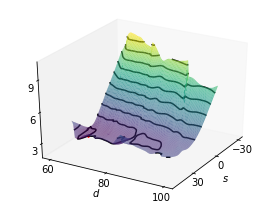

In [10]:
X, Y = np.meshgrid(x2_range ,Lp_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Loss landscape "+r" $x_3=-15.5 ~ h=30$")
plt.tight_layout()
plt.savefig("landscape-x2-Lp.pdf")


plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Training data")
# plt.ylim([-30, 0])



fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([-11.565677642822266], [62.2564697265625], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 30)
ax.set_xticks([0, -30, -60])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$x_2$", labelpad=-5)
ax.set_yticks([60, 80, 100])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$L_p$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()



x1 = L_p.item()/2.0
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
X += Y/2
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([-11.565677642822266 + x1], [62.2564697265625], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 30)
ax.set_xticks([30, 0, -30])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$s$", labelpad=-5)
ax.set_yticks([60, 80, 100])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$d$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-2.pdf")

In [11]:
x3, x2 = -15.864848136901855, -11.565677642822266
x3, x2 =  torch.tensor(x3, dtype=torch.float), torch.tensor(x2, dtype=torch.float)

Lp_range = np.linspace(60, 100, 40*4 + 1)
h_range = np.linspace(20, 30, 10*4 + 1)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(Lp_range), len(h_range)))
for i in range(len(Lp_range)):
    for j in range(len(h_range)):
        Lp, h = torch.tensor(Lp_range[i], dtype=torch.float), torch.tensor(h_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, Lp, x2, x3, h, N_s)

        out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        
            

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


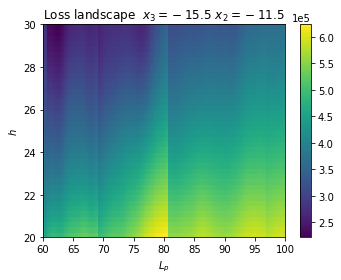

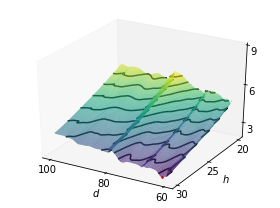

In [12]:
X, Y = np.meshgrid(Lp_range, h_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$L_p$")
plt.ylabel(r"$h$")
plt.title("Loss landscape "+r" $x_3=-15.5 ~ x_2=-11.5$")
plt.tight_layout()
plt.savefig("landscape-Lp-h.pdf")





x1 = L_p.item()/2.0
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([62.2564697265625], [30.0],  [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 120)
ax.set_xticks([60, 80, 100])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$d$", labelpad=-5)
ax.set_yticks([20, 25, 30])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$h$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-3.pdf")

# Some plots for the paper

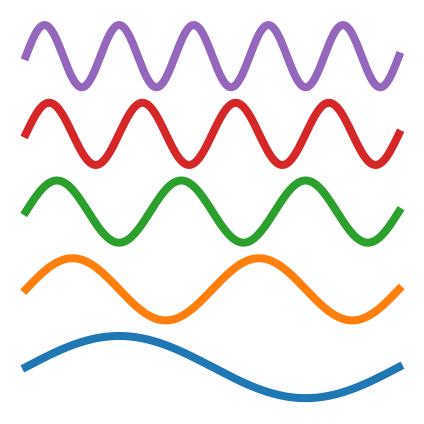

In [13]:
# Draw Fourier basis functions

xx = np.linspace(0, 1, 1001)

plt.figure(figsize=(6, 6))
dy = 2.5
shift = 0
for i in range(5):
    plt.plot(xx, np.sin(2*np.pi*(i+1)*xx)+shift*dy, color="C"+str(i),  linewidth=8.0)
    shift += 1.0
#     plt.plot(xx, np.cos(2*np.pi*(2*i+2)*xx)+shift*dy,   linewidth=4.0)
#     shift += 1.0
plt.axis('off'),
# ax = plt.gca()
# # ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.savefig("Fourier_basis_functions.pdf")



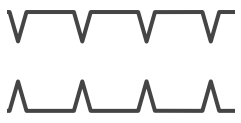

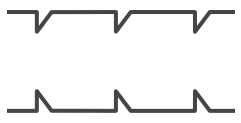

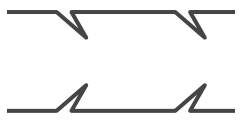

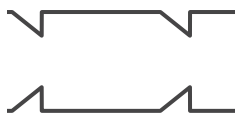

In [14]:
L_x = 500
L_ps = [65, 80, 120, 150]
x2s = [-L_ps[0]/2+ 8.5, -L_ps[1]/2, -L_ps[2]/2 + 30.0, -L_ps[3]/2 + 30.0]
x3s = [-L_ps[0]/2 + 17.0, -L_ps[1]/2 + 15, -L_ps[2]/2 + 15.0, -L_ps[3]/2 + 30.0]

hs = [29.9, 20, 26, 24]
for i in range(4):
    L_p = L_ps[i] 
    x1 = -L_p/2.0
    x2, x3 = x2s[i], x3s[i]
    h = hs[i]

    N_s = 2001
    X0,Y0 = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x2, x3, h, N_s)
    plt.figure(figsize=(6, 2))
    plt.plot(X0, 100-Y0, color="#464546", linewidth=4.0)
    plt.plot(X0, Y0, color="#464546", linewidth=4.0)
    plt.axis('off'),
    plt.xlim([-230, 0])
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.savefig("design_data_"+str(i)+".pdf")

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


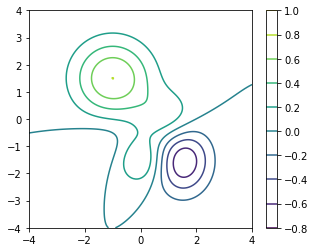

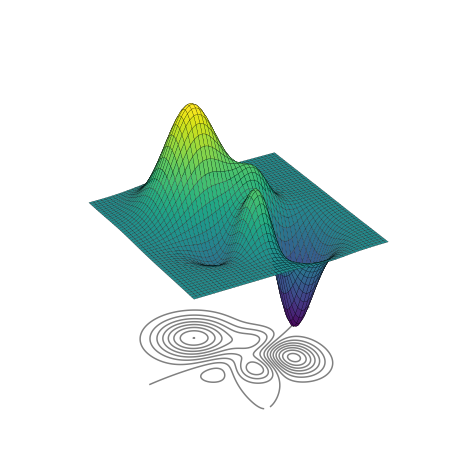

In [15]:
def Gaussian_helper(x, m, C):
    return np.exp(-0.5*np.dot(x - m , np.linalg.solve(C,x - m)))
    
def Gaussian(X, Y, m, C):
    nx, ny = X.shape
    Z = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            Z[ix, iy] = Gaussian_helper(np.array([X[ix, iy], Y[ix, iy]]), m, C)
    return Z

nx, ny = 200, 200
xx = np.linspace(-4, 4, nx)
yy = np.linspace(-4, 4, ny)
X, Y = np.meshgrid(xx ,yy)


Z = np.zeros((nx, ny))
Z += 0.8*Gaussian(X, Y, np.array([-1.0, 1.5]), np.array([[1.0, 0.0], [0.0, 1.0]]))
Z += 0.4*Gaussian(X, Y, np.array([1.0, 0.0]), np.array([[0.5, 0.0], [0.0, 0.5]]))
Z += 0.5*Gaussian(X, Y, np.array([0.0, -1.5]), np.array([[0.4, 0.0], [0.0, 0.4]]))
Z += -0.2*Gaussian(X, Y, np.array([-1.2, -1.0]), np.array([[0.8, 0.0], [0.0, 0.5]]))
Z += -0.8*Gaussian(X, Y, np.array([1.5, -1.5]), np.array([[0.5, 0.0], [0.0, 0.8]]))

plt.figure(figsize=(5,4))
# plt.pcolormesh(X, Y, Z)
plt.contour(X, Y, Z)
plt.colorbar()


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", lw=0.2, linestyles="solid", edgecolors='k', rstride=4, cstride=4)
# # ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
ax.contour(X, Y, Z, 15, colors="grey", linestyles="solid", offset=-1.0)
# ax.set_xlabel("x")
ax.set_axis_off()
# ax.set(zlim=(-0.5, 2))
ax.view_init(30, -120)
fig.savefig("optimization.pdf")
